## Prerequisites:
1] Download the Dataset from the below link which includes two folders, where there is a mask and without mask images in each folder respectively.
https://drive.google.com/drive/folders/1MjRmySJO1hHFAMT69f4M53hWjUUVHZPA?usp=sharing


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
imagePaths = list(paths.list_images('/content/drive/My Drive/dataset'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
print(len(data))
print(len(labels))

3833
3833


## Train MobileNet Model

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


## Label Encoding and Data Augmentation


In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 35s 366ms/step - loss: 0.3414 - accuracy: 0.8464 - val_loss: 0.1138 - val_accuracy: 0.9661
Epoch 2/20
95/95 [==============================] - 34s 355ms/step - loss: 0.1138 - accuracy: 0.9591 - val_loss: 0.0696 - val_accuracy: 0.9778
Epoch 3/20
95/95 [==============================] - 34s 355ms/step - loss: 0.0840 - accuracy: 0.9726 - val_loss: 0.0566 - val_accuracy: 0.9804
Epoch 4/20
95/95 [==============================] - 34s 355ms/step - loss: 0.0735 - accuracy: 0.9726 - val_loss: 0.0482 - val_accuracy: 0.9831
Epoch 5/20
95/95 [==============================] - 34s 357ms/step - loss: 0.0577 - accuracy: 0.9776 - val_loss: 0.0433 - val_accuracy: 0.9844
Epoch 6/20
95/95 [==============================] - 34s 358ms/step - loss: 0.0448 - accuracy: 0.9852 - val_loss: 0.0398 - val_accuracy: 0.9857
Epoch 7/20
95/95 [==============================] - 34s 358ms/step - loss: 0.0380 - accuracy

as we can see, we got almost 100% accuracy 

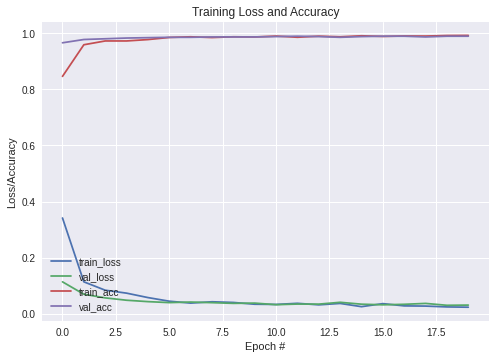

In [ ]:
N = EPOCHS
plt.style.use("seaborn")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
#To save the trained model
model.save('mask_recognition.h5')

## Make Predictions

### Required:
1] haarcascade classifier or any face detection model

2] Classifier which we saved above.

In [ ]:
# cascade classfier for face detection download from https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
cascPath = 'haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cascPath)
print('Classifier being loaded...')
model = load_model("mask_recognition.h5")
print('model being loaded...')

# choose your choice image or video
image_path=''

video_capture = cv2.VideoCapture(0)


if image_path!='':
    frame=cv2.imread(image_path)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),flags=cv2.CASCADE_SCALE_IMAGE)

    for (x, y, w, h) in faces:
            face_frame = frame[y:y+h,x:x+w]
            face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
            face_frame = cv2.resize(face_frame, (224, 224))
            face_frame = img_to_array(face_frame)
            face_frame = np.expand_dims(face_frame, axis=0)
            face_frame =  preprocess_input(face_frame)
            mask,withoutMask = model.predict(face_frame)[0]

            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
            cv2.putText(frame, label, (x, y- 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

            cv2.rectangle(frame, (x, y), (x + w, y + h),color, 2)
            # Display the resulting frame
            cv2.imshow('Video', frame)
            key=cv2.waitKey(0)
            if key==ord('q'):
                break

    cv2.destroyAllWindows()

else:
    while True:
    # Capture frame-by-frame
    
        ret, frame = video_capture.read()
        frame=frame.astype('uint8')
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(gray,
                                             scaleFactor=1.1,
                                             minNeighbors=5,
                                             minSize=(60, 60),flags=cv2.CASCADE_SCALE_IMAGE)
        
        faces_list=[]
        preds=[]
        for (x, y, w, h) in faces:
            face_frame = frame[y:y+h,x:x+w]
            face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
            face_frame = cv2.resize(face_frame, (224, 224))
            face_frame = img_to_array(face_frame)
            face_frame = np.expand_dims(face_frame, axis=0)
            face_frame =  preprocess_input(face_frame)
            faces_list.append(face_frame)
            if len(faces_list)>0:
                preds = model.predict(faces_list)
            for pred in preds:
                (mask, withoutMask) = pred
                label = "Mask" if mask > withoutMask else "No Mask"
                color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
                label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
                cv2.putText(frame, label, (x, y- 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

                cv2.rectangle(frame, (x, y), (x + w, y + h),color, 2)
             # Display the resulting frame
                cv2.imshow('Video', frame)
                key=cv2.waitKey(1)
                if key==ord('q'):
                    break

        
    video_capture.release()

    cv2.destroyAllWindows()